In [1]:
from skimage import io
from skimage.data import astronaut
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv, hsv2rgb
import numpy as np
import cv2
from MyCannyEdgeDetectorDemo import *

In [2]:
data=io.imread('captain.jpg').astype(np.float32)
img=np.transpose(data,(2,0,1))[:3,...] # transpose shape to (3,height,width)

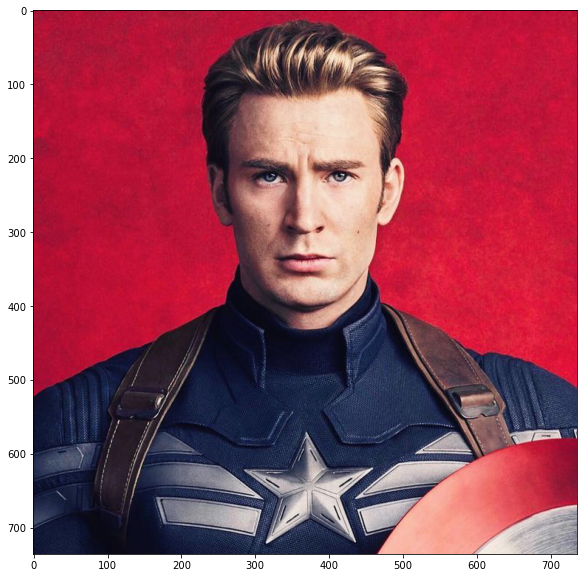

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(data.astype(np.uint8))
plt.show()

In [4]:
def my_bilateral_filter(img, d, sigma_s, sigma_r, padding_mode='zeros'):
    '''
    img: C*H*W, where C is channel (3 for rgb image, 1 for grayscale);
                  H and W are image height and width respectively.
    '''
    assert padding_mode in {'zeros', 'reflect', 'replicate'}, 'wrong padding mode'
    assert d & 1 == 1,'use odd number for d'
    kernel,_=get_gaussian_kernel(sigma_s,d)
    kernel=kernel@kernel.T

    kernel_size = kernel.shape
    h_k, w_k = kernel.shape  # kernel height and width
    padding = (h_k // 2, w_k // 2)

    if isinstance(padding, int):
        padding = (padding, padding)

    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)


    padded = img_padding(img, padding, padding_mode)

    C, H_in, W_in = img.shape  # batch size, rgb channel, Height, Width
    H_out = np.floor(H_in + 2 * padding[0] - kernel_size[0] + 1).astype(int)
    W_out = np.floor(W_in + 2 * padding[1] - kernel_size[1] + 1).astype(int)
    
    expanded = np.lib.stride_tricks.as_strided(
        padded,
        shape=(
            H_out,  # out channel height
            W_out,  # out channel width
            padded.shape[-3],  # input channel
            kernel.shape[-2],  # kernel height
            kernel.shape[-1],  # kernel width
        ),
        strides=(
            padded.strides[-2],  # H dimension
            padded.strides[-1],  # W dimension
            padded.strides[-3],  # input chennel
            padded.strides[-2],  # kernel height
            padded.strides[-1],  # kernel width
        ),
        writeable=False,
    )
    max_size=6e7
    HWmax=np.sqrt(max_size/h_k/w_k/C).astype(int)
    W=np.arange(HWmax,W_out,HWmax)
    W=np.append(W,W_out+1)
    H=np.arange(HWmax,H_out,HWmax)
    H=np.append(H,H_out+1)
    hi=0
    wi=0
    feature_map=np.zeros((H_out,W_out,C))
    for w in W:
        hi=0
        for h in H:
            part=expanded[hi:h,wi:w,...]
            
            color_dist=(part-part[...,[h_k // 2],[w_k // 2],None]).sum(axis=-3)
            
            gr=np.exp(-(color_dist/sigma_r)**2/2)
            Wp=(gr*kernel)
            Wp/=np.sum(Wp,axis=(-1,-2),keepdims=True)

            Wp=np.lib.stride_tricks.as_strided(
                Wp,
                shape=(*Wp.shape[:2],C,*Wp.shape[2:]),
                strides=(*Wp.strides[:2],0,*Wp.strides[2:]),
                writeable=False
            )
            feature_map[hi:h,wi:w]=np.einsum('...ij,...ij->...', part, Wp)
            hi=h
        wi=w
    return feature_map

In [5]:
%%time
result=my_bilateral_filter(img, d=15,sigma_s=100,sigma_r=100)

CPU times: user 3.02 s, sys: 493 ms, total: 3.51 s
Wall time: 3.53 s


**his wrinkles and pimples are all gone, now he looks 10 years younger.**

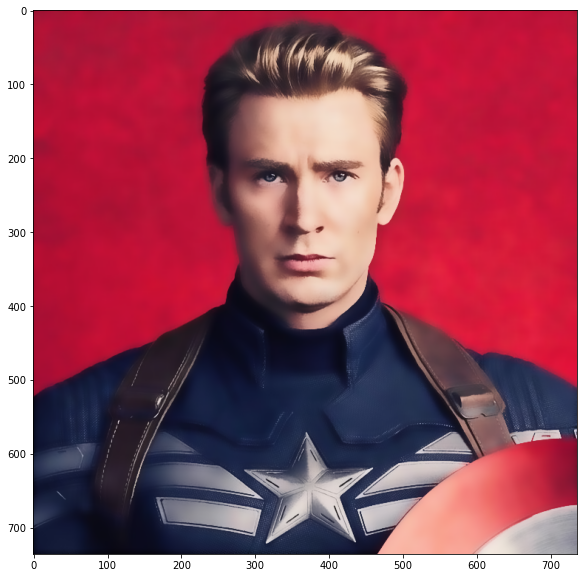

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(result.astype(np.uint8))
plt.show()

### enhance saturation

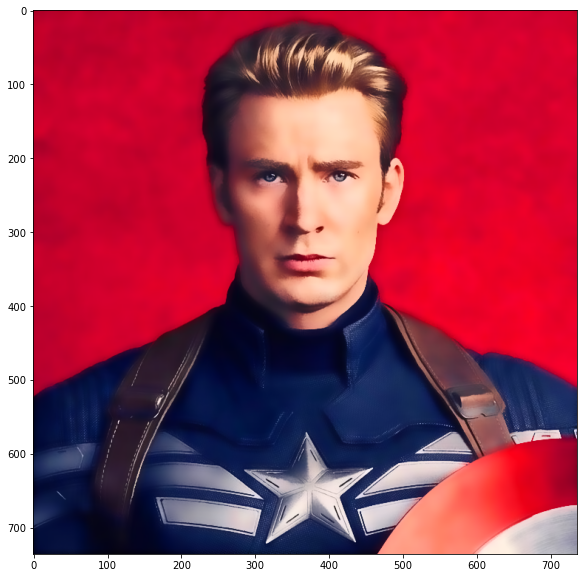

In [7]:
hsv_r = rgb2hsv(result/255) # hsv
hsv_r[...,1]*=1.4 #saturation
hsv_r[...,2]*=1.1 # value
hsv_r[...,1]=np.clip(hsv_r[...,1],0,1)
hsv_r[...,2]=np.clip(hsv_r[...,2],0,1)
result_ce=hsv2rgb(hsv_r)*255
plt.figure(figsize=(10,10))
plt.imshow(result_ce.astype(np.uint8))
plt.show()

### color quantization

In [8]:
@jit(nopython=True, cache=True)
def calc_closest(img,centroids,masks):
    # assign pixels to the closest centroid
    for i in range(img.shape[0]):
        color=img[i]
        diff=centroids-color
        dist=(diff*diff).sum(axis=1)
        masks[:,i]=False
        masks[np.argmin(dist),i]=True

In [9]:
def KNN_color_quantization(data,N):
    img=data.reshape((-1,3)).astype(np.int64)
    h=img.shape[0]
    centroids=img[np.random.choice(img.shape[0], N, replace=False)]
    for _ in range(5):
        masks=np.zeros((centroids.shape[0],h),dtype=np.bool)
        calc_closest(img,centroids,masks)
        # update new centers
        for i in range(masks.shape[0]):
            centroids[i]=(img[masks[i]].mean(axis=0)).astype(np.int64)
    # replace pixel with centroid values
    for i in range(centroids.shape[0]):
        img[masks[i]]=centroids[i]
    img=img.reshape(data.shape)
    return img

In [10]:
%%time
result_cq=KNN_color_quantization(result_ce,N=20)

CPU times: user 3.46 s, sys: 14.9 ms, total: 3.48 s
Wall time: 3.47 s


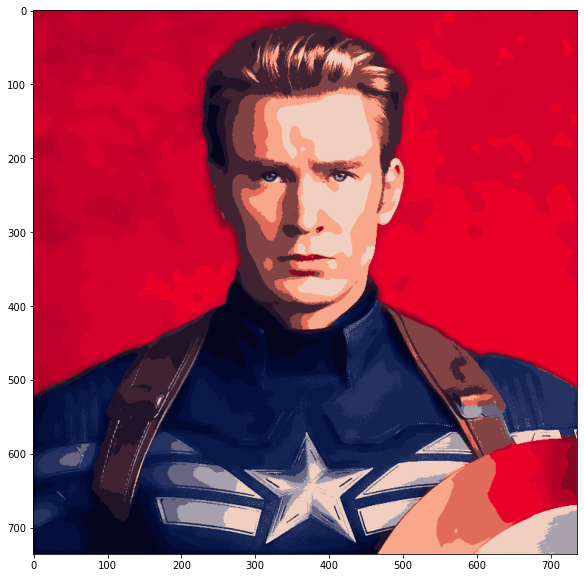

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(result_cq.astype(np.uint8))
plt.show()

## edge detection
**a tiny modification at non-max suppression so edges can have line width larger than 1.**

In [12]:
%%time
# find edge from original image
my_edge = myCannyEdgeDetector(data, 0.1, 0.3,line_width=3)

CPU times: user 335 ms, sys: 197 µs, total: 335 ms
Wall time: 335 ms


**Looks really good here, feels like an artist sketch. Only flaw is his right cheek, where edge is missing.**

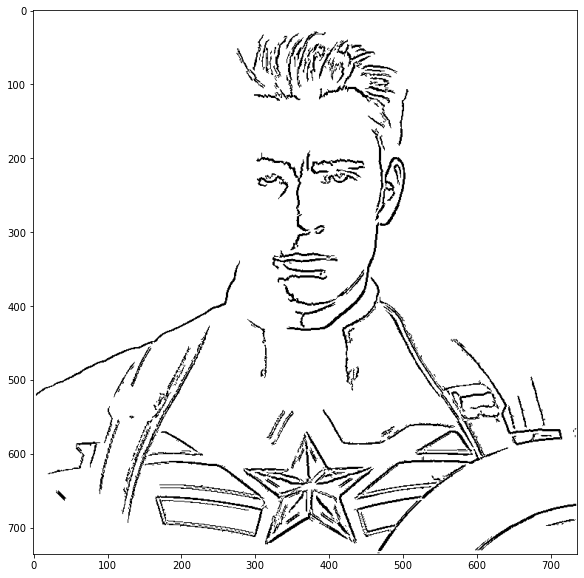

In [13]:
plt.figure(figsize=(10,10))
plt.imshow( ~my_edge, cmap='gray')
plt.show()

## Add edge

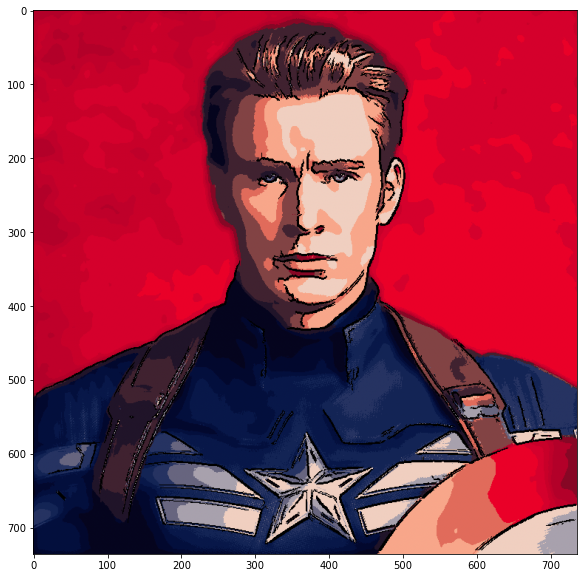

In [14]:
hsv_r = rgb2hsv(result_cq/255)
hsv_r[my_edge,2]=0
result_edge=hsv2rgb(hsv_r)
plt.figure(figsize=(10,10))
plt.imshow(result_edge)
plt.show()